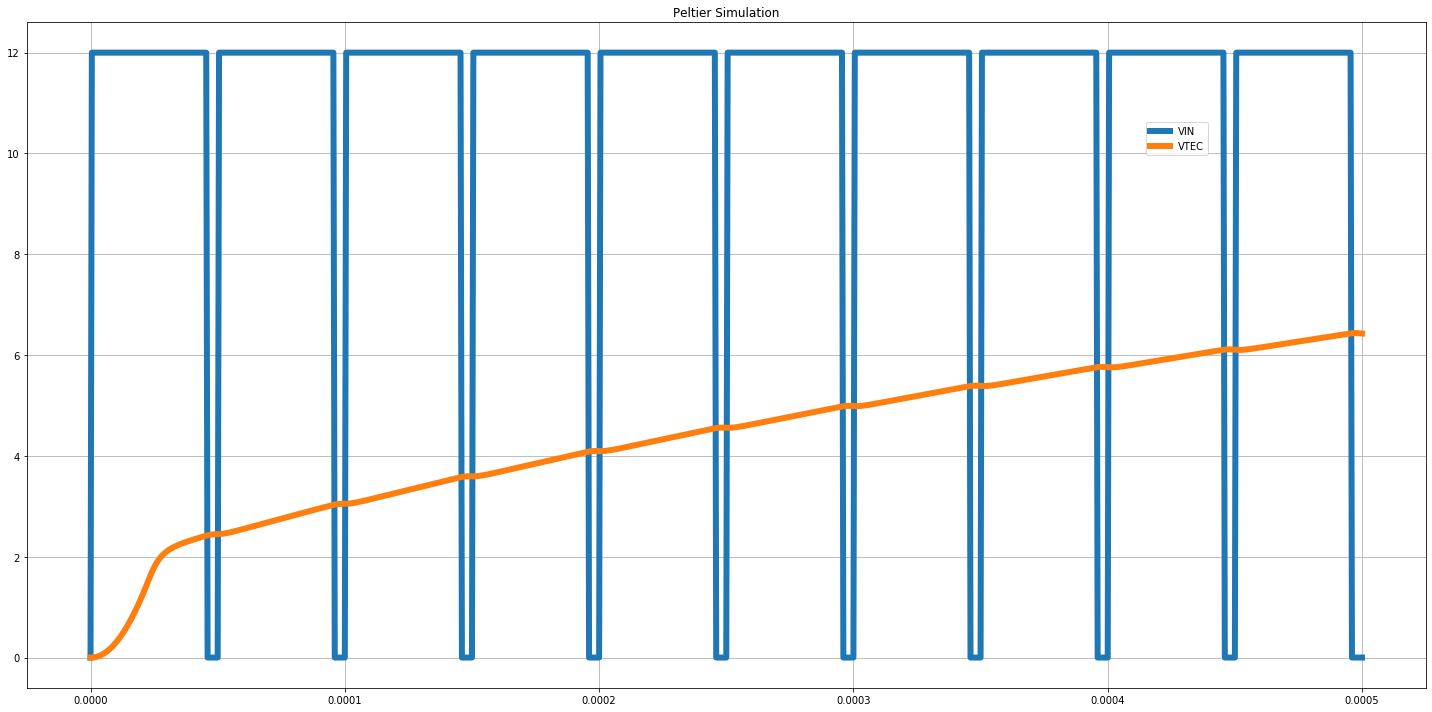

In [35]:
import math
import numpy as np
import matplotlib.pyplot as plt

from PySpice.Unit import *

from PySpice.Probe.Plot import plot
from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Doc.ExampleTools import find_libraries

spice_library = SpiceLibrary('/Users/chris/Dropbox/Books/spicelib/')

circuit = Circuit('TEC Model')
circuit.include(spice_library['SMA6J12A'])

# 100 us -> 10 kHz
#  50 us -> 20 kHz
source = circuit.PulseVoltageSource('input', 'pwm', circuit.gnd, 
                           initial_value=0@u_V, pulsed_value=12@u_V,
                           pulse_width=45@u_us, period=50@u_us)

## TEC is 12V, 5A -> 2.4 ohm
r_tec = 2.4@u_Ω
inductor = 10@u_uH

Rtec = circuit.R('TEC', 'TECP', 'TECM', r_tec)
L1 = circuit.L(1, 'pwm', 'TECP', inductor)
L2 = circuit.L(2, circuit.gnd, 'TECM', inductor)

C5 = circuit.C(5, 'TECP', 'TECM', 2*47@u_uF)

circuit.X('D1', 'SMA6J12A', 'TECP', 'snub')
circuit.X('D2', 'SMA6J12A', 'snub', 'TECM')

Rtec.minus.add_current_probe(circuit)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
step_time = source.period / 100
analysis = simulator.transient(step_time=step_time, end_time=source.period*10)
  
figure = plt.figure(1, (20, 10))

plot(analysis['pwm'], linewidth=2)
plot(analysis['TECP'] - analysis['TECM'], linewidth=2)

plt.title("Peltier Simulation")
plt.grid()
plt.legend(('VIN', 'VTEC'), loc=(.8,.8))
plt.tight_layout()
plt.show()